In [415]:
import collections
import sys
import os
import logging

from sortedcontainers import SortedList
from matplotlib.lines import Line2D  
from matplotlib.patches import Circle  

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

In [70]:
# parse bed file and restore the coordinates of all genes
class GENE:
    def __init__( self , ID:str = '' , sp:str='' ,chrom:str='', start:int=0 , end:int=0 , order:str='+' , pos:int=0 ):
        self.ID, self.sp , self.chrom = ID , sp, chrom
        self.start , self.end , self.order , self.pos =  int(start) , int(end) , order , int( pos )
        self.seq = ''
        pass 

    def __repr__( self ):
        return "%s is %d gene on the chromosome %s of %s, %d-%d"%( self.ID, self.pos, self.chrom, self.sp ,
                                                                  self.start , self.end )
    def __str__( self ):
        return self.ID

class CHROMOSOME:
    def __init__( self, ID:str='' , sp:str='' ):
        self.ID , self.sp = ID,sp
        self.genes = SortedList( key = lambda x:(x.start,x.ID) )   # collections of all genes on this chromosome
        self.terminal_cnts = []                                   # count the times of position that was broken as block border
        self.region_tuples = []                                  # store the tuples represents the collinear blocks (start, end, genes)
        self.inter_mat = self.insul_score = None                                   # global block break signals and insulation scores along chromosomes
        pass
    
    def add_gene( self , tmp_gene ):
        self.genes.add( tmp_gene )
        self.terminal_cnts.append( 0 )
        pass

    def assign_pos_for_genes( self ):
        for idx,tmp_gene in enumerate( self.genes ) :
            tmp_gene.pos = idx
        pass

    def __len__( self ):
        return len( self.genes )

    def __repr__( self ):
        return "%s chromosome %s contains %d genes"%( self.sp , self.ID, len(self.genes) )
        
        

def parse_bed_file( file_name:str , sp:str = '' , genes_dic:dict={} , chroms_dic:dict={} ):
    print( "parsing %s"% (file_name) )
    
    tmp_genes , tmp_chroms = {}, {}                  # temporal dictionary to current annotations
    with open( file= file_name ) as f:
        datas = f.readlines()
        for tmp_line in datas:
            tmp_chr, tmp_s, tmp_e, tmp_id, _, tmp_ord = tmp_line.strip().split()
            tmp_gene= GENE( ID=tmp_id , chrom=tmp_chr , sp=sp , start=tmp_s , end=tmp_e , order=tmp_ord )  # parse a line to a gene object
            tmp_genes[tmp_id] = tmp_gene
            
            if tmp_chroms.get( tmp_chr ) == None:
                tmp_chroms[ tmp_chr ] = CHROMOSOME( ID=tmp_chr , sp=sp )
            tmp_chroms[ tmp_chr ].add_gene( tmp_gene )
    # finish reading all annotations in the bed file 
    print( "finish parsing %d lines in %s "% ( len(tmp_genes), file_name) )
    
    for tmp_id,tmp_chr in tmp_chroms.items():
        tmp_chr.assign_pos_for_genes()
        print( "assigning %d genes in %s"% ( len(tmp_chr.genes), tmp_id) )

    genes_dic[sp]=tmp_genes    # transfer the result to controller
    chroms_dic[sp]=tmp_chroms
    
    print( "finish parsing %s"% (file_name) )
    return None
    
    
        

In [102]:
'''
sp_list = [ i.strip('.bed') for i in os.listdir('/home/gujianhui/BLOCKOME/02.blocks/') if i.endswith('.bed')]
## i.strip('.bed') will remove the tail 'e' from taxon name, for example: Secale_cereale.bed → Secale_cereal . Maybe is a bug?
'''

sp_list = [ i[:-4] for i in os.listdir('/home/gujianhui/BLOCKOME/02.blocks/') if i.endswith('.bed')]
bed_dir = '/home/gujianhui/BLOCKOME/02.blocks/'

genes_dic = {}
chroms_dic = {}
for tmp_sp in sp_list:
    parse_bed_file( os.path.join(bed_dir, tmp_sp+'.bed') , tmp_sp , genes_dic=genes_dic , chroms_dic= chroms_dic )

parsing /home/gujianhui/BLOCKOME/02.blocks/Leersia_perrieri.bed
finish parsing 38961 lines in /home/gujianhui/BLOCKOME/02.blocks/Leersia_perrieri.bed 
assigning 5363 genes in 1
assigning 4265 genes in 2
assigning 4742 genes in 3
assigning 3488 genes in 4
assigning 3143 genes in 5
assigning 3092 genes in 6
assigning 3099 genes in 7
assigning 2710 genes in 8
assigning 2134 genes in 9
assigning 2039 genes in 10
assigning 2737 genes in 11
assigning 2149 genes in 12
finish parsing /home/gujianhui/BLOCKOME/02.blocks/Leersia_perrieri.bed
parsing /home/gujianhui/BLOCKOME/02.blocks/Eragrostis_curvula.bed
finish parsing 55182 lines in /home/gujianhui/BLOCKOME/02.blocks/Eragrostis_curvula.bed 
assigning 6185 genes in 1
assigning 4329 genes in 2
assigning 5621 genes in 3
assigning 4895 genes in 4
assigning 4854 genes in 5
assigning 3095 genes in 6
assigning 3806 genes in 7
assigning 1 genes in Contig0
assigning 12 genes in Contig2
assigning 1881 genes in Contig4
assigning 7 genes in Contig5
assign

In [51]:
# # show the composition of all chromosome lengths in the dataset
# chrom_lens = []
# for tmp_sp_chroms in chroms_dic.values():
#     for tmp_chrom in tmp_sp_chroms.values():
#         if len(tmp_chrom)>10:
#             chrom_lens.append( np.log10( len(tmp_chrom) ) )


# plt.hist( chrom_lens , log=True)

In [99]:
class BLOCK:
    def __init__( self , ID:str='' ,sp1:str='' , sp2:str='' ,chrom1:str='' , chrom2:str='' ):
        self.ID = ID
        self.sp1, self.chrom1 , self.start1, self.end1 = sp1, chrom1 , 0 , 0
        self.sp2, self.chrom2 , self.start2, self.end2 = sp2, chrom2 , 0 , 0
        self.pairs = [ ]
        pass

    def add_pair( self, gene_pair ):
        self.pairs.append( gene_pair)
        pass
    
    def get_region_locations( self ):
        tmp_min1 = tmp_min2 = 999999999999
        tmp_max1 = tmp_max2 =  0
        
        for tmp_pair in self.pairs:
            tmp_min1 = min( tmp_min1 , tmp_pair.gene1.pos )
            tmp_min2 = min( tmp_min2 , tmp_pair.gene2.pos )
            tmp_max1 = max( tmp_max1 , tmp_pair.gene1.pos )
            tmp_max2 = max( tmp_max2 , tmp_pair.gene2.pos )

        self.chrom1, self.chrom2 = tmp_pair.gene1.chrom, tmp_pair.gene2.chrom
        self.start1, self.end1 = tmp_min1, tmp_max1
        self.start2, self.end2 = tmp_min2, tmp_max2
        pass

    def __len__( self ):
        return len( self.pairs )
    
    def __repr__( self ):
        return "BLOCK(%s_%s:%d-%d, %s_%s:%d-%d)"%(self.sp1, self.chrom1 , self.start1 , self.end1 , 
                                                 self.sp2, self.chrom2 , self.start2 , self.end2 ) 

class PAIR:
    def __init__( self,gene1 ,gene2 ,score:int ,ID:str=''  ):
        self.gene1 , self.gene2, self.score = gene1 , gene2, score

    def __repr__(self):
        return "%s --- %s  %d"%( self.gene1 , self.gene2, self.score )



def parse_anchors_file( path:str='./' , file_name:str='sp1.sp2.anchors' , genes_dic:dict = {} ):
    sp1, sp2, _ = file_name.split('.')
    tmp_blocks = [ ]
    with open( os.path.join(path, file_name) ) as f:
        datas = f.readlines()
        for tmp_line in datas:
            if tmp_line.startswith('#'):
                tmp_blocks.append(BLOCK( ID=str(len(tmp_blocks)), sp1=sp1, sp2=sp2) )
            else:
                # read the anchor pair line, transfer this pair into assigned block
                gene1, gene2, tmp_score = tmp_line.strip().split('\t')
                tmp_pair = PAIR( gene1 = genes_dic[sp1][gene1] , gene2= genes_dic[sp2][gene2] , score=int(tmp_score) )
                tmp_blocks[-1].add_pair( tmp_pair )
    
    for tmp_block in tmp_blocks:
        tmp_block.get_region_locations() 
        
    return tmp_blocks

In [103]:
anchors_dir='/home/gujianhui/BLOCKOME/02.blocks/anchors_dir/'
all_blocks = []
for tmp_anchor_file in os.listdir( anchors_dir ):
    if tmp_anchor_file.endswith('lifted.anchors'):
        continue
    elif tmp_anchor_file.endswith('.anchors'):
        all_blocks.extend( parse_anchors_file( path= anchors_dir , file_name= tmp_anchor_file , genes_dic= genes_dic) )

In [104]:
# len(all_blocks) , sum([ len(_.pairs) for _ in all_blocks])

## transfer all blocks information to corresponding chromosomes
for tmp_block in all_blocks:
    tmp_n = len(tmp_block.pairs)
    chroms_dic[ tmp_block.sp1 ][ tmp_block.chrom1 ].region_tuples.append( (tmp_block.start1, tmp_block.end1 , tmp_n ) )
    chroms_dic[ tmp_block.sp2 ][ tmp_block.chrom2 ].region_tuples.append( (tmp_block.start2, tmp_block.end2 , tmp_n ) )

for tmp_chrom_dic in chroms_dic.values():
    for tmp_chrom in tmp_chrom_dic.values():
        tmp_chrom.blocks_sum = sum( [i[1]-i[0] for i in tmp_chrom.region_tuples] )    # sum the length of all blocks
        tmp_chrom.paired_sum = sum( [i[2] for i in tmp_chrom.region_tuples] )         # sum the number of paired genes in all blocks

Text(0, 0.5, 'log10(number_of_paired_genes)')

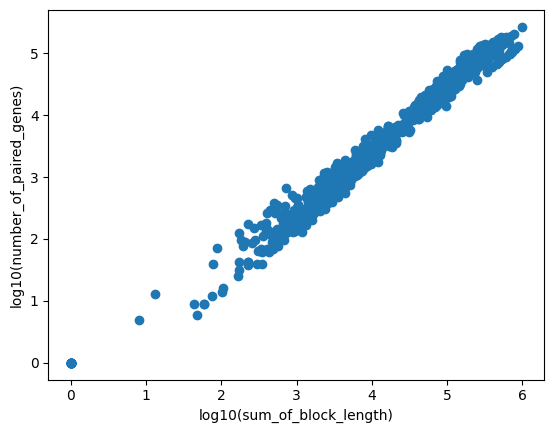

In [118]:

plt.scatter( [ np.log10( tmp_chrom.blocks_sum+1 ) for j in chroms_dic.values() for tmp_chrom in j.values() if  len(tmp_chrom.genes) > 100  ],
            [ np.log10( tmp_chrom.paired_sum+1 ) for j in chroms_dic.values() for tmp_chrom in j.values() if  len(tmp_chrom.genes) > 100  ],
            )

plt.xlabel('log10(sum_of_block_length)')
plt.ylabel('log10(number_of_paired_genes)')

In [326]:
def get_inter_mat( chrom:CHROMOSOME , window:int = 5 , slide:int = 2 , block_len_limit:int = 10):
    n = len( chrom )//window +1
    # initialize the interaction matrix
    inter_mat = np.zeros( (n, n) )
    for tmp_block_s, tmp_block_e , tmp_block_n in chrom.region_tuples:
        if tmp_block_n < block_len_limit:
            continue
        inter_mat[ tmp_block_s//window ][ tmp_block_e//window ] += 1*np.log2(tmp_block_n)
    return inter_mat

def plot_region_inter( df , start:int=0 , end:int=9999999, tri:bool = False , mark:str='.' , size:int=1):
    end = min( end , len(df) )
    if tri:
        points = [ ( (i+j)//2, (j-i)//2 , df[i,j]) for i in range(start,end) for j in range(i,end) ]   # coordinate transformation
        plt.scatter( x=[i[0] for i in points],
                    y=[i[1] for i in points],
                   c=[ i[2] for i in points] , cmap="Oranges" , marker=mark , s=size)
        plt.colorbar( label='interaction')
    else:    
        plot_df = df[start:end+1 , start:end+1]
        sns.heatmap( plot_df , mask=np.tril(np.ones_like(plot_df, dtype=bool), k=0)  , cmap="Oranges" )
        plt.title( "region:%d-%d"%(start, end ) )
    return None

def calculate_insulation_score(interaction_matrix, bin_size:int =50 , window_size:int = 5):  
    """  
    计算每个bin的Insulation Score。  
  
    参数:  
    - interaction_matrix: 二维numpy数组，互作矩阵。  
    - bin_size: int，每个bin的大小（单位通常是kb或Mb）。  
    - window_size: int，用于计算Insulation Score的窗口大小（以bin为单位）。  
  
    返回:  
    - insulation_scores: 一维numpy数组，每个bin的Insulation Score。  
    """  
    n_bins = interaction_matrix.shape[0]  
    insulation_scores = np.zeros(n_bins)  
  
    # 遍历每个bin作为中心  
    for i in range(n_bins):  
        # 计算上游窗口  
        upstream_start = max(0, i - window_size)  
        upstream_end = i  
        upstream_sum = np.sum(interaction_matrix[upstream_start:upstream_end, i])  
  
        # 计算下游窗口  
        downstream_start = i + 1  
        downstream_end = min(n_bins, i + window_size + 1)  
        downstream_sum = np.sum(interaction_matrix[i, downstream_start:downstream_end])  

        # print( upstream_sum , downstream_sum ,i )
  
        # 简单的Insulation Score计算（这里使用差异，可以调整）  
        insulation_scores[i] = (downstream_sum - upstream_sum) / (downstream_sum + upstream_sum + 1e-9)  # 加小量防止除零  
  
    return insulation_scores  

def _mesh_data(bin_coords):
    x, y = np.meshgrid(bin_coords, bin_coords)
    sin45 = np.sin(np.radians(45))
    x_, y_ = x * sin45 + y * sin45, x * sin45 - y * sin45
    return x_, y_

def rotation_coordinate(start,end,hic_mat_reso):
    # rotatate coordinate matrix 45 degrees
    # adopt from FAN-C module
    bin_coords = np.true_divide(range(start//hic_mat_reso,end//hic_mat_reso+1),np.sqrt(2))
    x_, y_=_mesh_data(bin_coords)
    return x_, y_

In [341]:
# Calculate the blcok break point signal in the chromosomes
for tmp_sp in chroms_dic.values():
    for tmp_chrom in tmp_sp.values():
        if len(tmp_chrom) > 500:           # calculate the chromosome that longer than 500 genes
            tmp_inter_mat = get_inter_mat( chrom=tmp_chrom , window=30 , block_len_limit=10 )
            tmp_chrom.inter_mat = tmp_inter_mat
            tmp_chrom.insul_score = calculate_insulation_score( tmp_chrom.inter_mat , window_size= 20 )
            tmp_chrom.window_length = 30             # the number of genes in a window
            tmp_chrom.block_len_limit = 10

            tmp_chrom.insul_limit = -0.8
            prev = 0
            tmp_chrom.split_regions = [ ]
            for tmp_idx,tmp_score in enumerate( tmp_chrom.insul_score ):
                if tmp_score < tmp_chrom.insul_limit:
                    tmp_chrom.split_regions.append( (prev*tmp_chrom.window_length , tmp_idx*tmp_chrom.window_length ) )
                    prev = tmp_idx
            if prev != tmp_idx:
                tmp_chrom.split_regions.append( (prev*tmp_chrom.window_length , tmp_idx*tmp_chrom.window_length ) )   # add the tail part

In [342]:
chroms_dic['Oryza_sativa']['5'].split_regions

[(0, 990), (990, 1020), (1020, 1290), (1290, 1320), (1320, 3390)]

In [360]:
tmp_df = get_inter_mat( chrom=chroms_dic['Eleusine_indica']['2'] , window=30 , block_len_limit=10) 


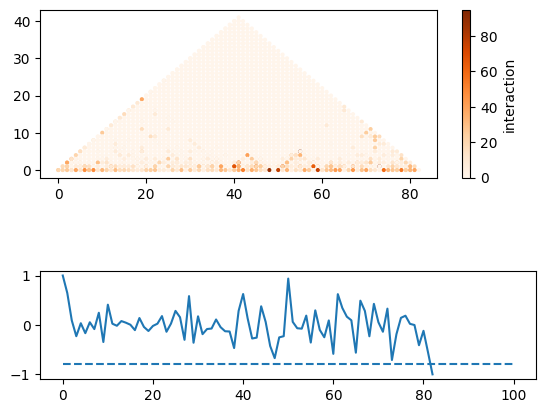

In [361]:
plt.subplot(211)
plot_region_inter( tmp_df , tri=True , mark='.' , size=15)

plt.subplot(313)
plt.plot( calculate_insulation_score( tmp_df , window_size= 20) )
plt.hlines( y = -0.8 , xmax=100 , xmin=0 , linestyles='--')
# sns.heatmap( tmp_df , mask=np.tril(np.ones_like(tmp_df, dtype=bool), k=0)  , cmap="Oranges" )
# plt.gca().tick_params(axis='y', which='both', length=0) 
# plt.xticks([])
# plt.yticks([])

In [401]:
split_status = []

for tmp_sp, tmp_chroms in chroms_dic.items():
    tmp_block_n = tmp_block_len = tmp_genome_size = 0
    
    for tmp_chrom in tmp_chroms.values():
        if len( tmp_chrom ) > 500:
            tmp_genome_size += len(tmp_chrom)
            tmp_block_n += len( tmp_chrom.split_regions )
            tmp_block_len += sum( [ i[1]-i[0] for i in tmp_chrom.split_regions] )
    
    if tmp_block_n:
        split_status.append( (tmp_block_n , tmp_block_len/(tmp_block_n+1) , tmp_sp , tmp_genome_size) )

In [367]:
clade_dic = { 'BOP':['Achnatherum_splendens','Aegilops_bicornis','Aegilops_longissima','Aegilops_searsii','Aegilops_sharonensis','Aegilops_speltoides','Aegilops_tauschii','Aegilops_umbellulata','Alopecurus_myosuroides','Avena_atlantica','Avena_eriantha','Avena_insularis','Avena_longiglumis','Avena_nuda','Avena_sativa','Avena_strigosa','Brachypodium_distachyon','Brachypodium_hybridum','Brachypodium_stacei','Brachypodium_sylvaticum','Bromus_tectorum','Dactylis_glomerata','Hordeum_marinum','Hordeum_spontaneum','Hordeum_vulgare','Lolium_multiflorum','Lolium_perenne','Lolium_rigidum','Poa_annua','Poa_infirma','Poa_pratensis','Poa_supina','Poa_trivialis','Pseudoroegneria_libanotica','Puccinellia_tenuiflora','Secale_cereale','Stipa_capillata','Thinopyrum_elongatum','Triticum_aestivum','Triticum_monococcum','Triticum_timopheevii','Triticum_turgidum','Triticum_urartu','Ampelocalamus_luodianensis','Bonia_amplexicaulis','Dendrocalamus_brandisii','Dendrocalamus_latiflorus','Dendrocalamus_sinicus','Guadua_angustifolia','Hsuehochloa_calcarea','Melocanna_humilis','Olyra_latifolia','Otatea_glauca','Phyllostachys_edulis','Raddia_distichophylla','Raddia_guianensis','Rhipidocladum_racemiflorum','Leersia_perrieri','Oryza_alta','Oryza_australiensis','Oryza_barthii','Oryza_brachyantha','Oryza_coarctata','Oryza_eichingeri','Oryza_glaberrima','Oryza_glumaepatula','Oryza_granulata','Oryza_longistaminata','Oryza_meridionalis','Oryza_nivara','Oryza_officinalis','Oryza_punctata','Oryza_rhizomatis','Oryza_rufipogon','Oryza_sativa','Zizania_latifolia','Zizania_palustris'],
            'PACMAD':['Alloteropsis_semialata','Bothriochloa_decipiens','Cenchrus_alopecuroides','Cenchrus_americanus','Cenchrus_fungigraminus','Cenchrus_purpureus','Coix_aquatica','Coix_lacryma-jobi','Dichanthelium_oligosanthes','Digitaria_exilis','Echinochloa_colona','Echinochloa_crus-galli','Echinochloa_haploclada','Echinochloa_oryzoides','Eremochloa_ophiuroides','Erianthus_fulvus','Microstegium_vimineum','Miscanthus_floridulus','Miscanthus_lutarioriparius','Miscanthus_sinensis','Panicum_hallii','Panicum_miliaceum','Panicum_virgatum','Paspalum_notatum','Paspalum_vaginatum','Saccharum_spontaneum','Saccharum_x_sp.','Setaria_italica','Setaria_viridis','Sorghum_bicolor','Themeda_triandra','Tripidium_rufipilum','Zea_mays','Aeluropus_littoralis','Chloris_gayana','Chloris_virgata','Cleistogenes_songorica','Cynodon_dactylon','Cynodon_transvaalensis','Eleusine_coracana','Eleusine_indica','Eragrostis_curvula','Eragrostis_nindensis','Eragrostis_tef','Leptochloa_chinensis','Orinus_kokonorica','Oropetium_thomaeum','Sporobolus_pyramidalis','Sporobolus_stapfianus','Zoysia_japonica','Zoysia_matrella','Zoysia_pacifica','Phragmites_australis'],
            'BASE':['Pharus_latifolius' , 'Streptochaeta_angustifolia'],
            'OUTGROUP':['Ananas_comosus'] }

sp_clade_dic = {}
for tmp_clade,sps in clade_dic.items():
    for tmp_sp in sps:
        sp_clade_dic[tmp_sp] = tmp_clade

color_pan = {'BOP':'#8ECFC9' , 'PACMAD':'#FA7F6F' , 'BASE':'#FFBE7A' , 'OUTGROUP':'#E7DAD2' }

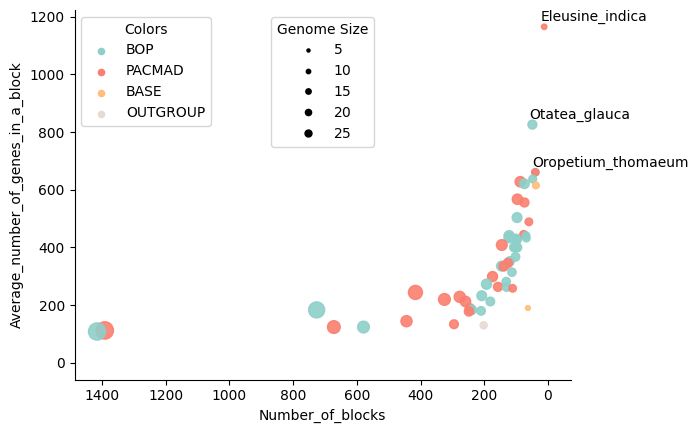

In [447]:
fig, ax = plt.subplots()

split_status.sort( key=lambda x:-x[1])

plt.scatter( [ i[0] for i in split_status ] ,
            [ i[1] for i in split_status ] ,
            c=[ color_pan.get(sp_clade_dic[i[2]]) for i in split_status] ,
           s=[ i[3]/1000 for i in split_status ] , alpha= 0.9)

plt.xlabel('Number_of_blocks')
plt.ylabel('Average_number_of_genes_in_a_block')
plt.gca().invert_xaxis()



scatter_artists = []  
  
# 遍历color_pan字典，为每个颜色创建一个散点并添加到列表中  
for label, color in color_pan.items():  
    # 注意：这里我们实际上并没有在图中绘制有意义的点，只是创建了散点艺术家  
    # 在实际应用中，你可能想要将这些点绘制在数据的实际位置上  
    scatter_artists.append(plt.scatter(0, 0, c=color, label=label , s=20))  # 使用空列表作为x和y数据  
  
# 现在我们可以添加图例了，但请注意上面的scatter调用实际上并没有在图中绘制任何内容  
# 如果你想要在图中看到这些点，你需要为scatter提供实际的x和y数据  
legend1 = plt.legend(handles=scatter_artists, title='Colors') 

ax.add_artist(legend1)

tmp_scatter = plt.scatter([0 for i in range(5)],[0 for i in range(5)], c='black' ,
                          s=[ (5000+5000*i)/1000 for i in range(5)] ,
                          label= [str(5+5*i)+'k' for i in range(5)]  )

legend2 = ax.legend(*tmp_scatter.legend_elements(prop='sizes'),
                     loc="upper center", title="Genome Size")


plt.scatter(0,0,c='white',s=100 )   # mask the legend


plt.gca().text( split_status[0][0]+10 ,split_status[0][1]+20, split_status[0][2] )
plt.gca().text( split_status[1][0]+10 ,split_status[1][1]+20 , split_status[1][2] )
plt.gca().text( split_status[3][0]+10 ,split_status[3][1]+20 , split_status[3][2] )

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [450]:
for tmp_sp, tmp_chroms in chroms_dic.items():
    for tmp_chrom in tmp_chroms.values():
        if len( tmp_chrom ) > 500:
            for tmp_region in tmp_chrom.split_regions:
                print( tmp_sp, tmp_chrom.ID, tmp_region[0] , tmp_region[1] )

Leersia_perrieri 1 0 90
Leersia_perrieri 1 90 1680
Leersia_perrieri 1 1680 3270
Leersia_perrieri 1 3270 5310
Leersia_perrieri 1 5310 5340
Leersia_perrieri 2 0 900
Leersia_perrieri 2 900 1560
Leersia_perrieri 2 1560 1980
Leersia_perrieri 2 1980 4260
Leersia_perrieri 3 0 2760
Leersia_perrieri 3 2760 3210
Leersia_perrieri 3 3210 3330
Leersia_perrieri 3 3330 4710
Leersia_perrieri 3 4710 4740
Leersia_perrieri 4 0 90
Leersia_perrieri 4 90 180
Leersia_perrieri 4 180 210
Leersia_perrieri 4 210 660
Leersia_perrieri 4 660 690
Leersia_perrieri 4 690 720
Leersia_perrieri 4 720 1080
Leersia_perrieri 4 1080 1230
Leersia_perrieri 4 1230 2610
Leersia_perrieri 4 2610 2760
Leersia_perrieri 4 2760 3450
Leersia_perrieri 4 3450 3480
Leersia_perrieri 5 0 750
Leersia_perrieri 5 750 840
Leersia_perrieri 5 840 900
Leersia_perrieri 5 900 2130
Leersia_perrieri 5 2130 2940
Leersia_perrieri 5 2940 3030
Leersia_perrieri 5 3030 3120
Leersia_perrieri 6 0 390
Leersia_perrieri 6 390 1290
Leersia_perrieri 6 1290 1590
Le